In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc
import pandas as pd
import scanpy as sc 
import sys 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl

warnings.filterwarnings('ignore')
sys.path.append('../../src')

from spaceoracle.plotting.cartography import Cartography
import celloracle as co
from celloracle.applications import Gradient_calculator
from celloracle.applications.scatter_to_grid import scatter_value_to_grid_value
from celloracle.applications.differentiation_flow import get_gradient, normalize_gradient
from spaceoracle.virtual_tissue import VirtualTissue

In [3]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [4]:
adata = adata[adata.obs.cell_type != 'DC']

In [5]:
%matplotlib inline

In [6]:
import json

with open('./colors.json', 'r') as f:
    color_dict = json.load(f)

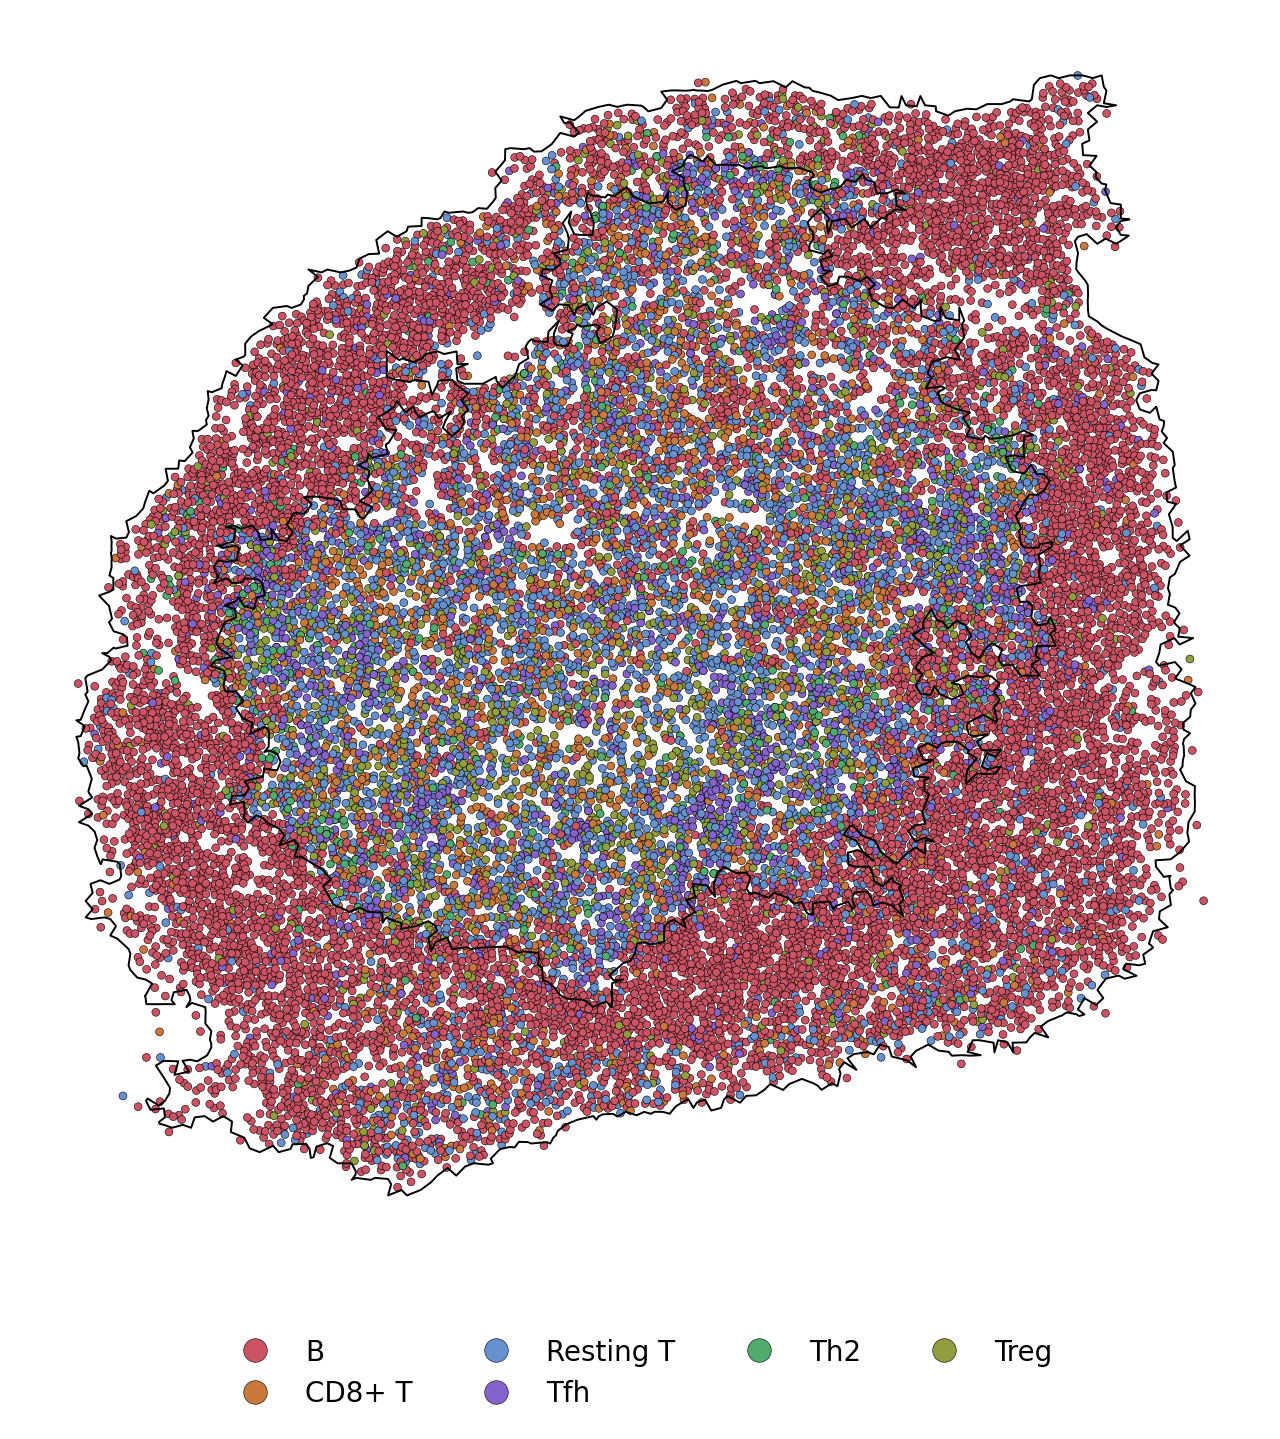

In [7]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['figure.dpi'] = 100


import alphashape

ct_points_wt = {}
for ct in adata.obs['cell_type'].unique():
    points = np.asarray(
        adata[adata.obs['cell_type'] == ct].obsm['spatial'])
    delta = 30
    points = np.vstack(
        (points +[-delta,delta], points +[-delta,-delta], 
        points +[delta,delta], points +[delta,-delta]))
    ct_points_wt[ct] = points

adatax = adata

sns.scatterplot(data=adatax.obs, 
    x=adatax.obsm['spatial'][:,0], 
    y=adatax.obsm['spatial'][:,1],
    s=8,
    edgecolor='black',
    linewidth=0.2,
    hue='cell_type',
    legend='brief', palette=color_dict)
plt.axis('off')

alpha_shape = alphashape.alphashape(ct_points_wt['Resting T'], alpha=0.038)
for geom in alpha_shape.geoms:
    if geom.area > 800000:
        plt.plot(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color='black', alpha=1, linewidth=0.7)
        
alpha_shape = alphashape.alphashape(ct_points_wt['B'], alpha=0.038)
for geom in alpha_shape.geoms:
    if geom.area > 800000:
        plt.plot(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color='black', alpha=1, linewidth=0.7)
        
plt.legend(bbox_to_anchor=(0.5, -0.05), 
    loc='upper center', ncol=4, frameon=False, 
    markerscale=3, fontsize=10)

plt.savefig('./figures/spatial_celltypes.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [8]:
# sc.pl.dotplot(adata, 
#     var_names=['Ccr4', 'Foxp3', 'Il2ra', 'Cd8a', 'Cd4'], 
#     groupby='cell_type', layer='normalized_count', cmap='Greens', show=False)

# plt.show()

In [9]:
tonsil = VirtualTissue(
    adata = adata,
    annot = 'cell_type',
    betadatas_path = '/Volumes/SSD/lasso_runs/slideseq_mouse_lymphnode',
    ko_path = '/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode',
    color_dict=color_dict
)

# rename={
#     'T_follicular_helper': 'T Follicular\nHelper',
#     'T_CD8': 'T CD8+',
#     'T_CD4': 'T CD4+',
#     'B_germinal_center': 'B Germinal\nCenter',
#     'B_naive': 'B\nNaive',
#     'B_memory': 'B\nMemory',
# }

In [10]:
ligands = ['Il2', 'Il15', 'Il4', 'Cxcl13', 'Ccl5', 'Lgals9']
receptors = ['Il2ra', 'Cxcr4', 'Ccr4', 'Il4ra', 'Il6st', 'Cxcr5']
tf = ['Gata3', 'Prdm1', 'Pax5', 'Foxp3', 'Bcl6', 'Stat4']
randoms = ['Gata3', 'Cux2', 'Pten', 'Fosl2', 'Zkscan3', 'Tfcp2']

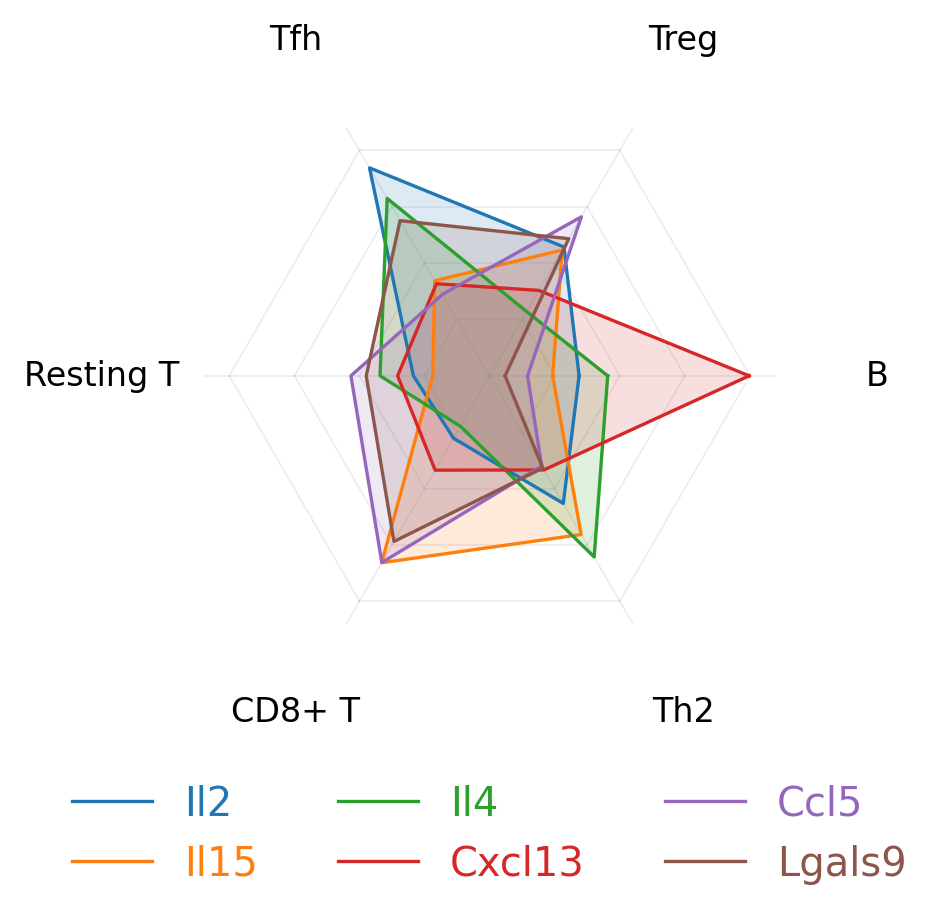

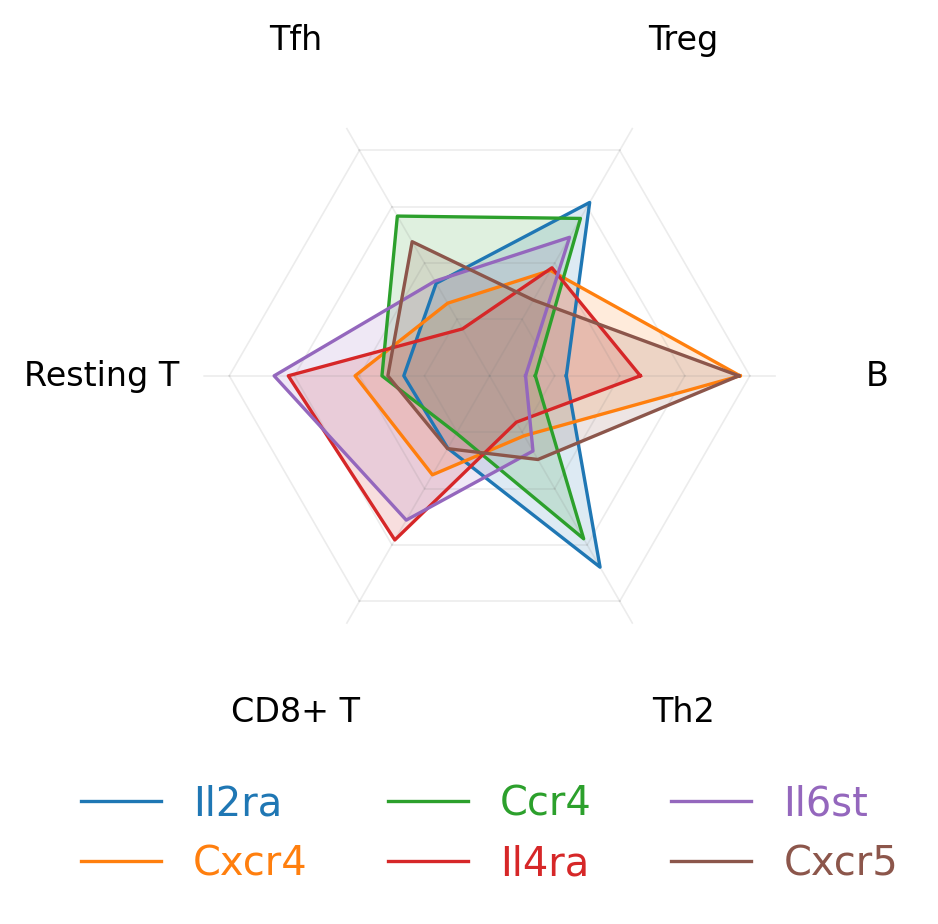

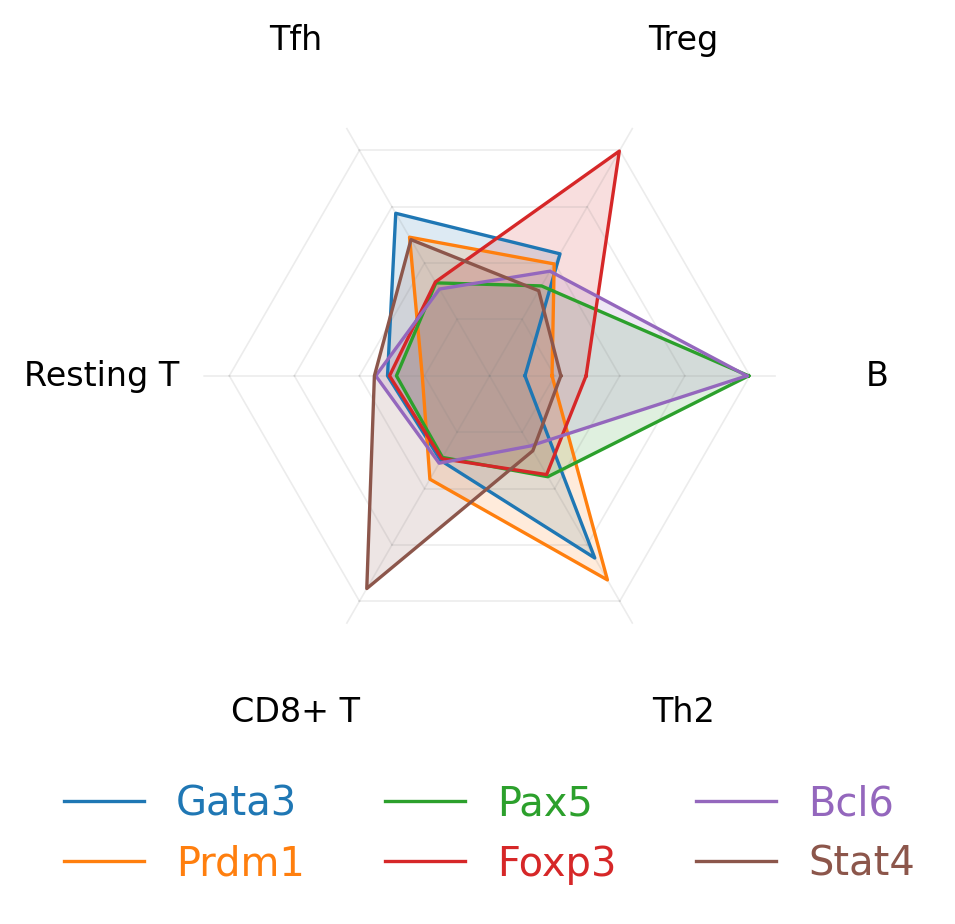

In [11]:
%matplotlib inline
tonsil.plot_radar(genes=ligands, 
    cache_path='../../notebooks/mouse_lymphnode_slideseq/', 
    figsize=(10, 4),
    dpi=120,
)
plt.savefig('spider_plot_ligands.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

tonsil.plot_radar(genes=receptors, 
    cache_path='../../notebooks/mouse_lymphnode_slideseq/', 
    figsize=(10, 4),
    dpi=120,
)
plt.savefig('spider_plot_receptors.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

tonsil.plot_radar(genes=tf, 
    cache_path='../../notebooks/mouse_lymphnode_slideseq/', 
    figsize=(10, 4),
    dpi=120,
)
plt.savefig('spider_plot_tf.svg', dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [16]:
from spaceoracle.beta import Betabase

bdb = Betabase(
    tonsil.adata, 
    tonsil.betadatas_path, 
    subsample=None, 
    float16=True, 
    obs_names=adata.obs_names,
    auto_load=False
)

In [17]:
interactions = {}

for ct in adata.obs.cell_type.unique():
    interactions[ct] = bdb.collect_interactions(cell_type=ct, annot='cell_type')

In [26]:
import commot as ct

df_ligrec = ct.pp.ligand_receptor_database(
                database='CellChat', 
                species='mouse', 
                signaling_type=None
            )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']  
complement_ligands = df_ligrec[df_ligrec.pathway == 'COMPLEMENT'].ligand.unique()

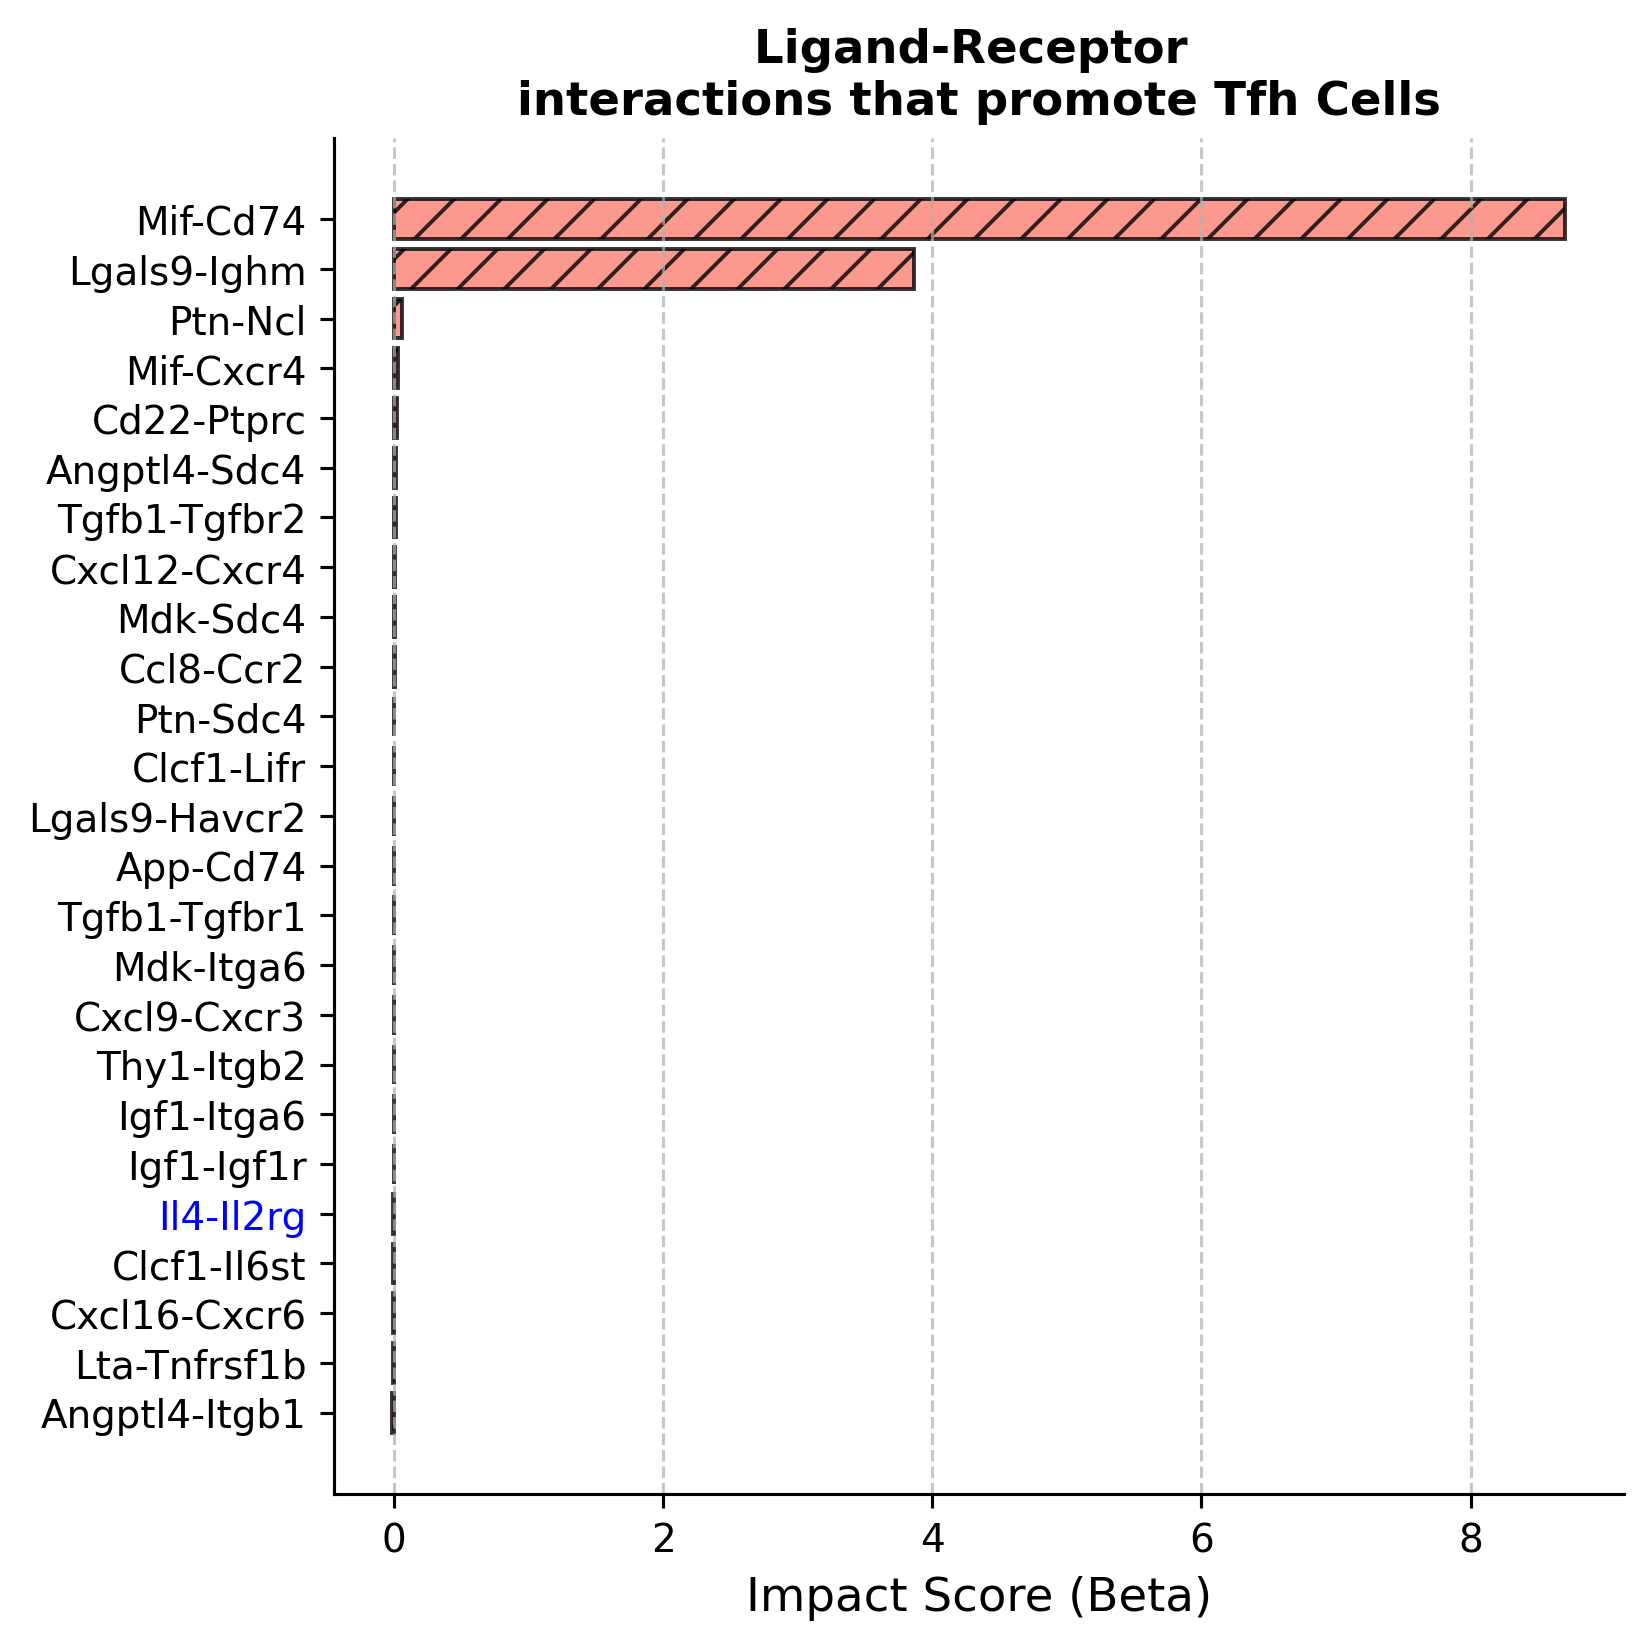

In [38]:
# dfr = interactions['Th2'].query('gene.isin(["Il2ra", "Il2rb", "Il2rg"])').groupby(
#     'interaction').sum().sort_values(
#     by='beta', ascending=False)

dfr = interactions['Tfh'].query('gene.isin(["Gata3", "Cxcl13", "Bcl6", "Foxp3"])').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)

    
dfr['beta'] = dfr['beta'] * 100
dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')


dfr = dfr.reset_index().query(
    '~interaction.str.contains("|".join(@complement_ligands))').set_index('interaction')


top_interactions = dfr.sort_values(
    by='beta', ascending=False).head(25)[::-1]

fig, ax = plt.subplots(figsize=(6, 6), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that promote Tfh Cells', fontsize=12, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

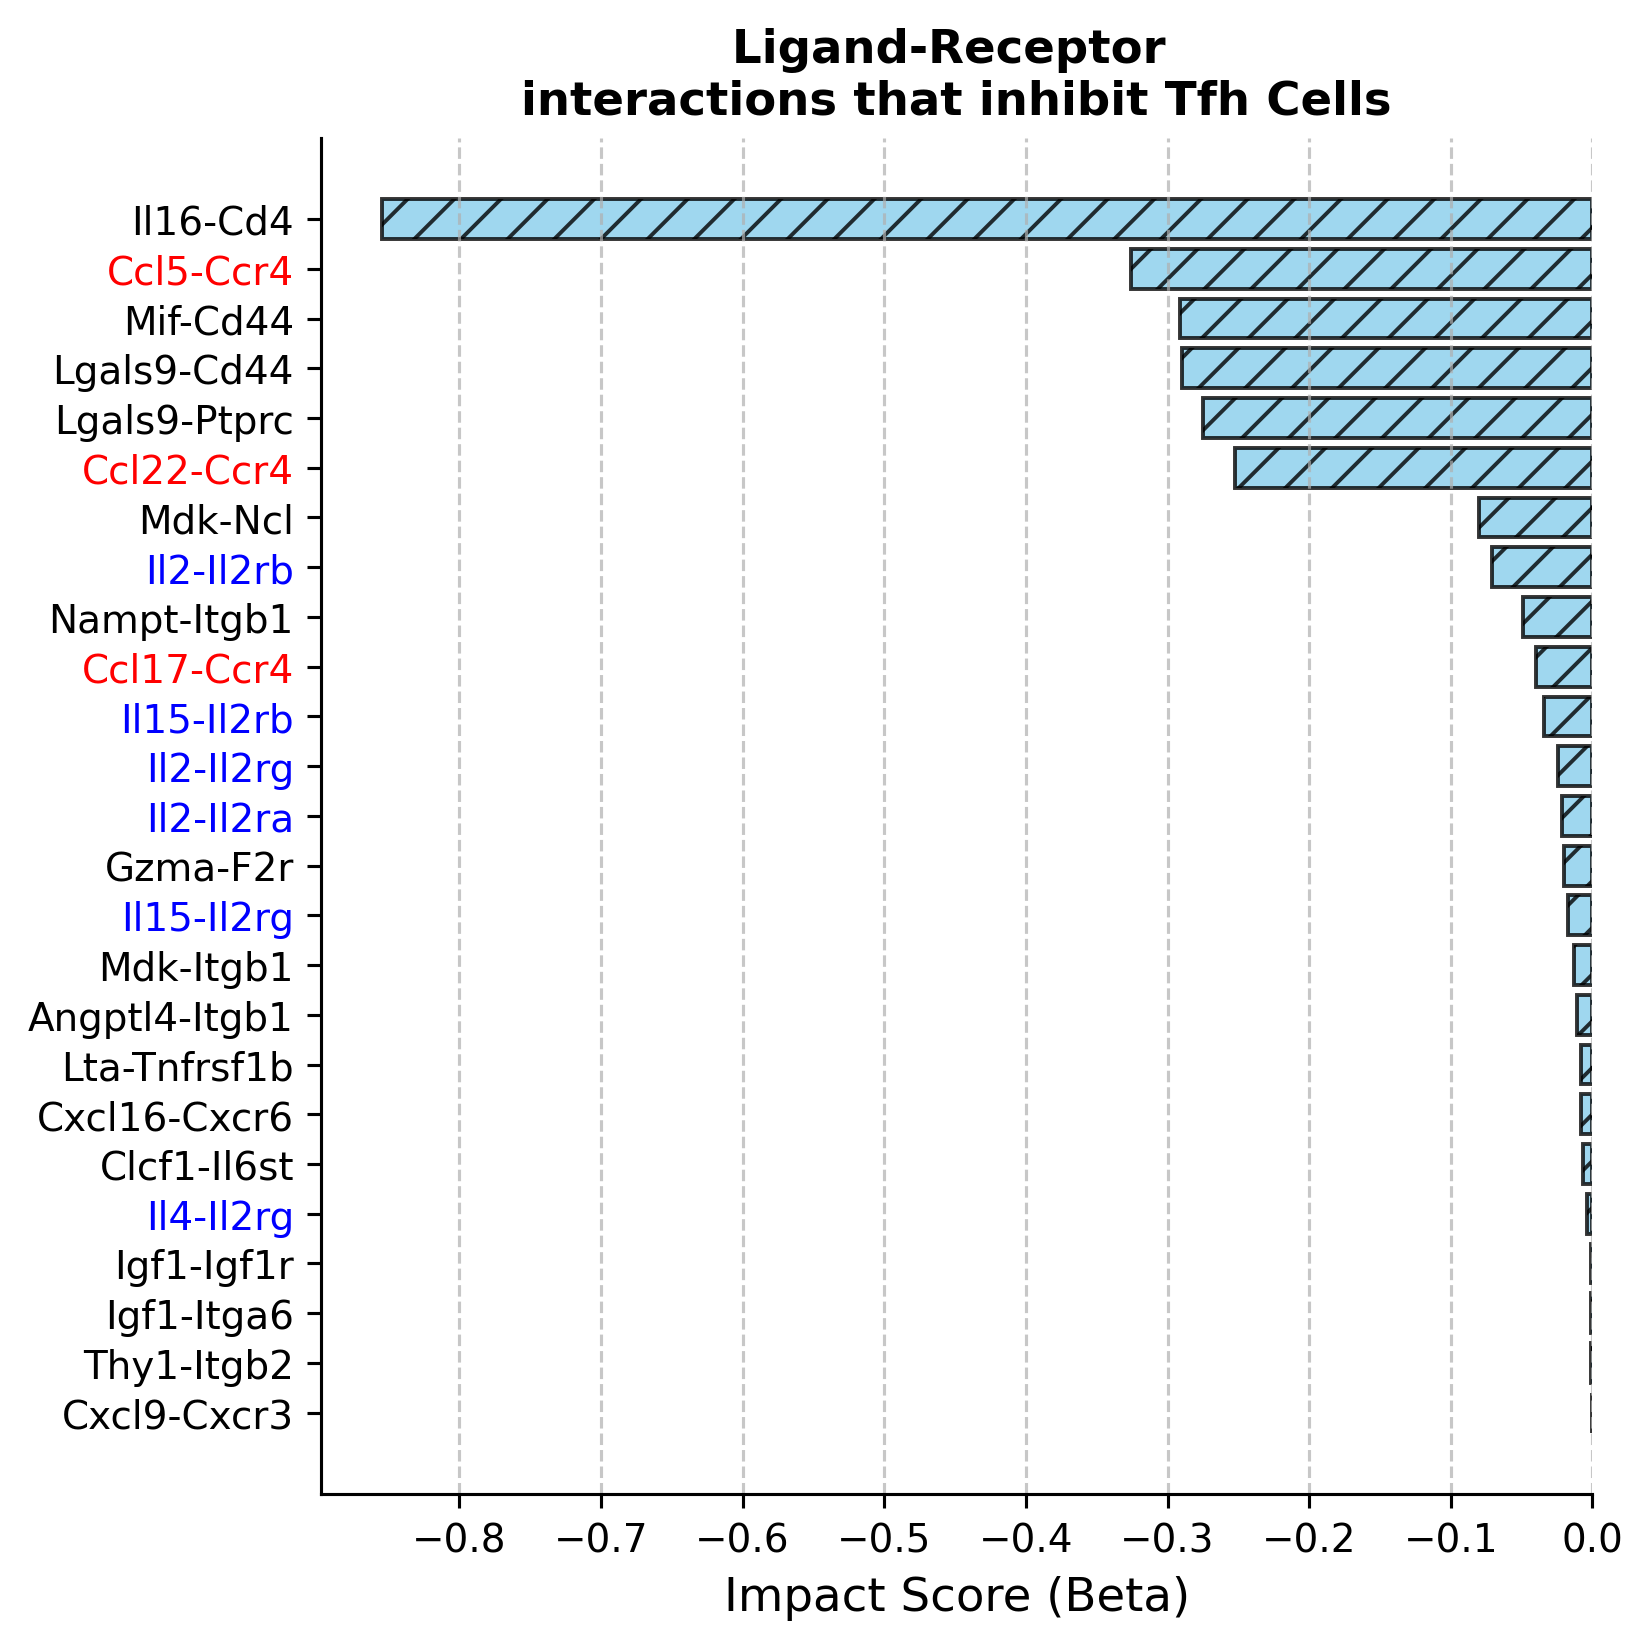

In [37]:
dfr = interactions['Tfh'].query('gene.isin(["Gata3", "Cxcl13", "Bcl6", "Foxp3"])').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)

    
dfr['beta'] = dfr['beta'] * 100
dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')


dfr = dfr.reset_index().query(
    '~interaction.str.contains("|".join(@complement_ligands))').set_index('interaction')


top_interactions = dfr.sort_values(
    by='beta', ascending=True).head(25)[::-1]

fig, ax = plt.subplots(figsize=(6, 6), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='skyblue', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that inhibit Tfh Cells', fontsize=12, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
dfr = interactions['Tfh'].query('gene.isin(["Gata3", "Cxcl13", "Bcl6", "Foxp3"])').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)

    
dfr['beta'] = dfr['beta'] * 100
dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')


dfr = dfr.reset_index().query(
    '~interaction.str.contains("|".join(@complement_ligands))').set_index('interaction')


top_interactions = dfr.sort_values(
    by='beta', ascending=True).head(25)[::-1]

fig, ax = plt.subplots(figsize=(6, 6), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='skyblue', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that inhibit Tfh Cells', fontsize=12, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()